In [ ]:
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        """
        In a residual block, the use of two ConvBlock instances with one having
        an activation function and the other not is a design choice that promotes
        the learning of residual information.

        The purpose of a residual block is to learn the residual mapping between
        the input and output of the block. The first ConvBlock in the sequence,
        which includes an activation function, helps in capturing and extracting
        important features from the input. The activation function introduces
        non-linearity, allowing the network to model complex relationships
        between the input and output.

        The second ConvBlock does not include an activation function.
        It mainly focuses on adjusting the dimensions (e.g., number of channels)
        of the features extracted by the first ConvBlock. The absence of an
        activation function in the second ConvBlock allows the block to learn
        the residual information. By directly adding the output of the second
        ConvBlock to the original input, the block learns to capture the
        residual features or changes needed to reach the desired output.

        (Information and explanation above generated by ChatGPT)
        """
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, achieved through the addition operation, helps
        in propagating gradients during training and alleviates the vanishing
        gradient problem. It also facilitates the flow of information from earlier
        layers to later layers, allowing the network to learn more effectively.

        (Information and explanation above generated by ChatGPT)
        """
        return x + self.block(x)


In [3]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 9 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

        The network with 9 residual blocks consists of:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
#                 ConvolutionalBlock(
#                     num_features * 2,
#                     num_features * 1,
#                     is_downsampling=False,
#                     kernel_size=3,
#                     stride=2,
#                     padding=1,
#                     output_padding=1,
#                 ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))


In [4]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512.

        After the last layer, we apply a convolution to produce a 1-dimensional
        output.

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

In [6]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img


In [7]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "/kaggle/input/horse2zebra-dataset"
VAL_DIR = "/kaggle/input/horse2zebra-dataset"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
LOAD_MODEL = True if os.path.exists('/kaggle/working/models/genh.pth.tar') else False
# LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GENERATOR_H = "models/genh.pth.tar"
CHECKPOINT_GENERATOR_Z = "models/genz.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = "models/disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = "models/discz.pth.tar"

if not os.path.exists('/kaggle/working/models'):
    os.makedirs('/kaggle/working/models')
if not os.path.exists('/kaggle/working/outputs'):
    os.makedirs('/kaggle/working/outputs')

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)

using device: cuda


In [8]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "/kaggle/working/" + filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load("/kaggle/working/" + checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

import torchvision.transforms as T

train_d_losses=[]
train_g_losses=[]
def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    disc_H.train()
    disc_Z.train()
    gen_Z.train()
    gen_H.train()
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True, position=0)
    size_transform = T.Compose(
        [
            T.Resize((64, 64), antialias=True),
        ],
    )
    size_bigger_transform = T.Compose(
        [
            T.Resize((128, 128), antialias=True),
        ],
    )

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        train_d_losses.append(D_loss.item())

        # Train generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle losses
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            
            zebra_t = size_transform(zebra)
            horse_t = size_transform(horse)
            cycle_zebra_loss = l1(zebra_t, cycle_zebra)
            cycle_horse_loss = l1(horse_t, cycle_horse)

#             identity losses
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            zebra_t = size_bigger_transform(zebra)
            horse_t = size_bigger_transform(horse)
            identity_zebra_loss = l1(zebra_t, identity_zebra)
            identity_horse_loss = l1(horse_t, identity_horse)

            # total loss
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        train_g_losses.append(G_loss.item())
        
        if idx % 200 == 0:
            save_image(fake_horse * 0.5 + 0.5, f"/kaggle/working/outputs/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"/kaggle/working/outputs/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1), D_loss=D_loss.item(), G_loss=G_loss.item())


In [67]:
def show_plot(animal, fake_animal, cycle_animal):
    w = 10
    h = 10
    fig = plt.figure(figsize=(32, 32))
    columns = 3
    images = [None, animal[0], fake_animal[0], cycle_animal[0]]
    for i in range(1, columns + 1):
        img = images[i].cpu().permute(1, 2, 0)
        fig.add_subplot(1, columns, i)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [68]:
val_losses=[]
def test_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, L1, mse
):
    disc_H.eval()
    disc_Z.eval()
    gen_Z.eval()
    gen_H.eval()
    
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True, position=0)
    size_transform = T.Compose(
        [
            T.Resize((64, 64), antialias=True),
        ],
    )
    size_bigger_transform = T.Compose(
        [
            T.Resize((128, 128), antialias=True),
        ],
    )

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        with torch.no_grad():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2
            
        with torch.no_grad():
            # adversarial losses
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle losses
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            
            zebra_t = size_transform(zebra)
            horse_t = size_transform(horse)
            cycle_zebra_loss = L1(zebra_t, cycle_zebra)
            cycle_horse_loss = L1(horse_t, cycle_horse)

#             identity losses
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            zebra_t = size_bigger_transform(zebra)
            horse_t = size_bigger_transform(horse)
            identity_zebra_loss = L1(zebra_t, identity_zebra)
            identity_horse_loss = L1(horse_t, identity_horse)

            # total loss
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )
            
        val_losses.append(D_loss.item())

        if idx % 50 == 0:
            show_plot(horse, fake_zebra, cycle_horse)
            show_plot(zebra, fake_horse, cycle_zebra)
            save_image(fake_horse * 0.5 + 0.5, f"/kaggle/working/val_outputs/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"/kaggle/working/val_outputs/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1), D_loss=D_loss.item(), G_loss=G_loss.item())

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


  0%|          | 0/140 [00:00<?, ?it/s]

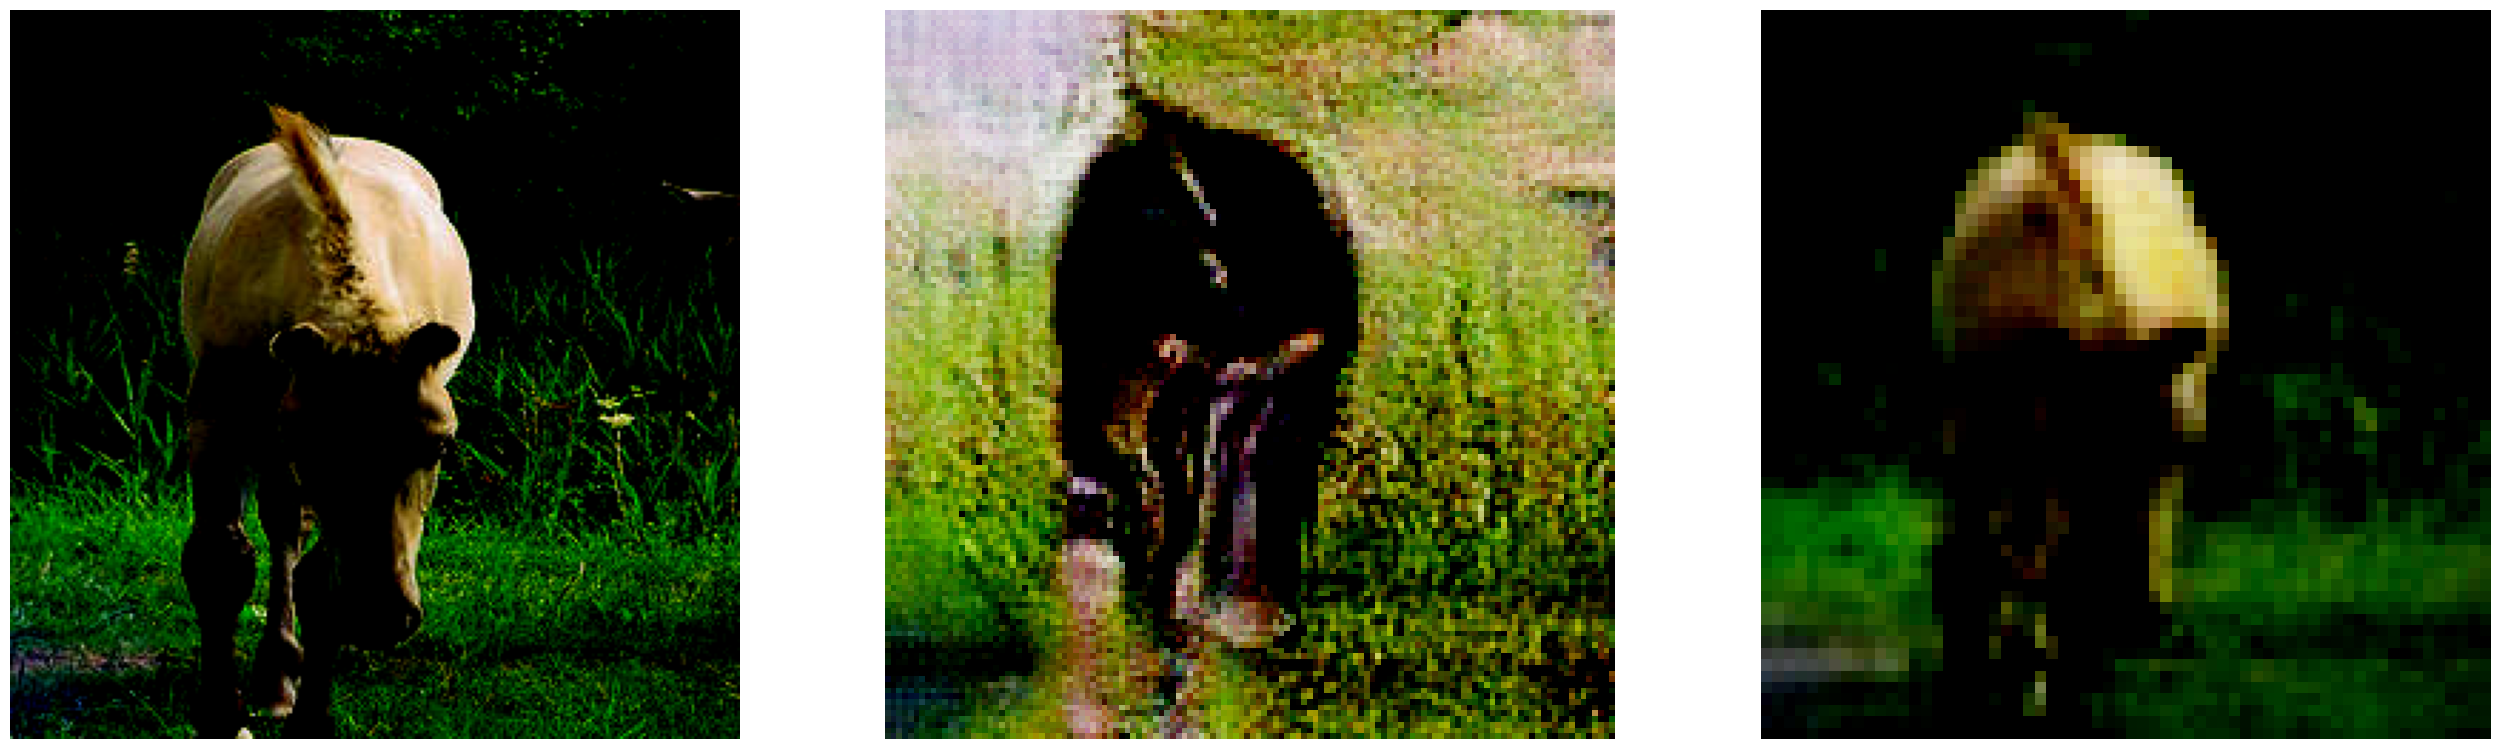

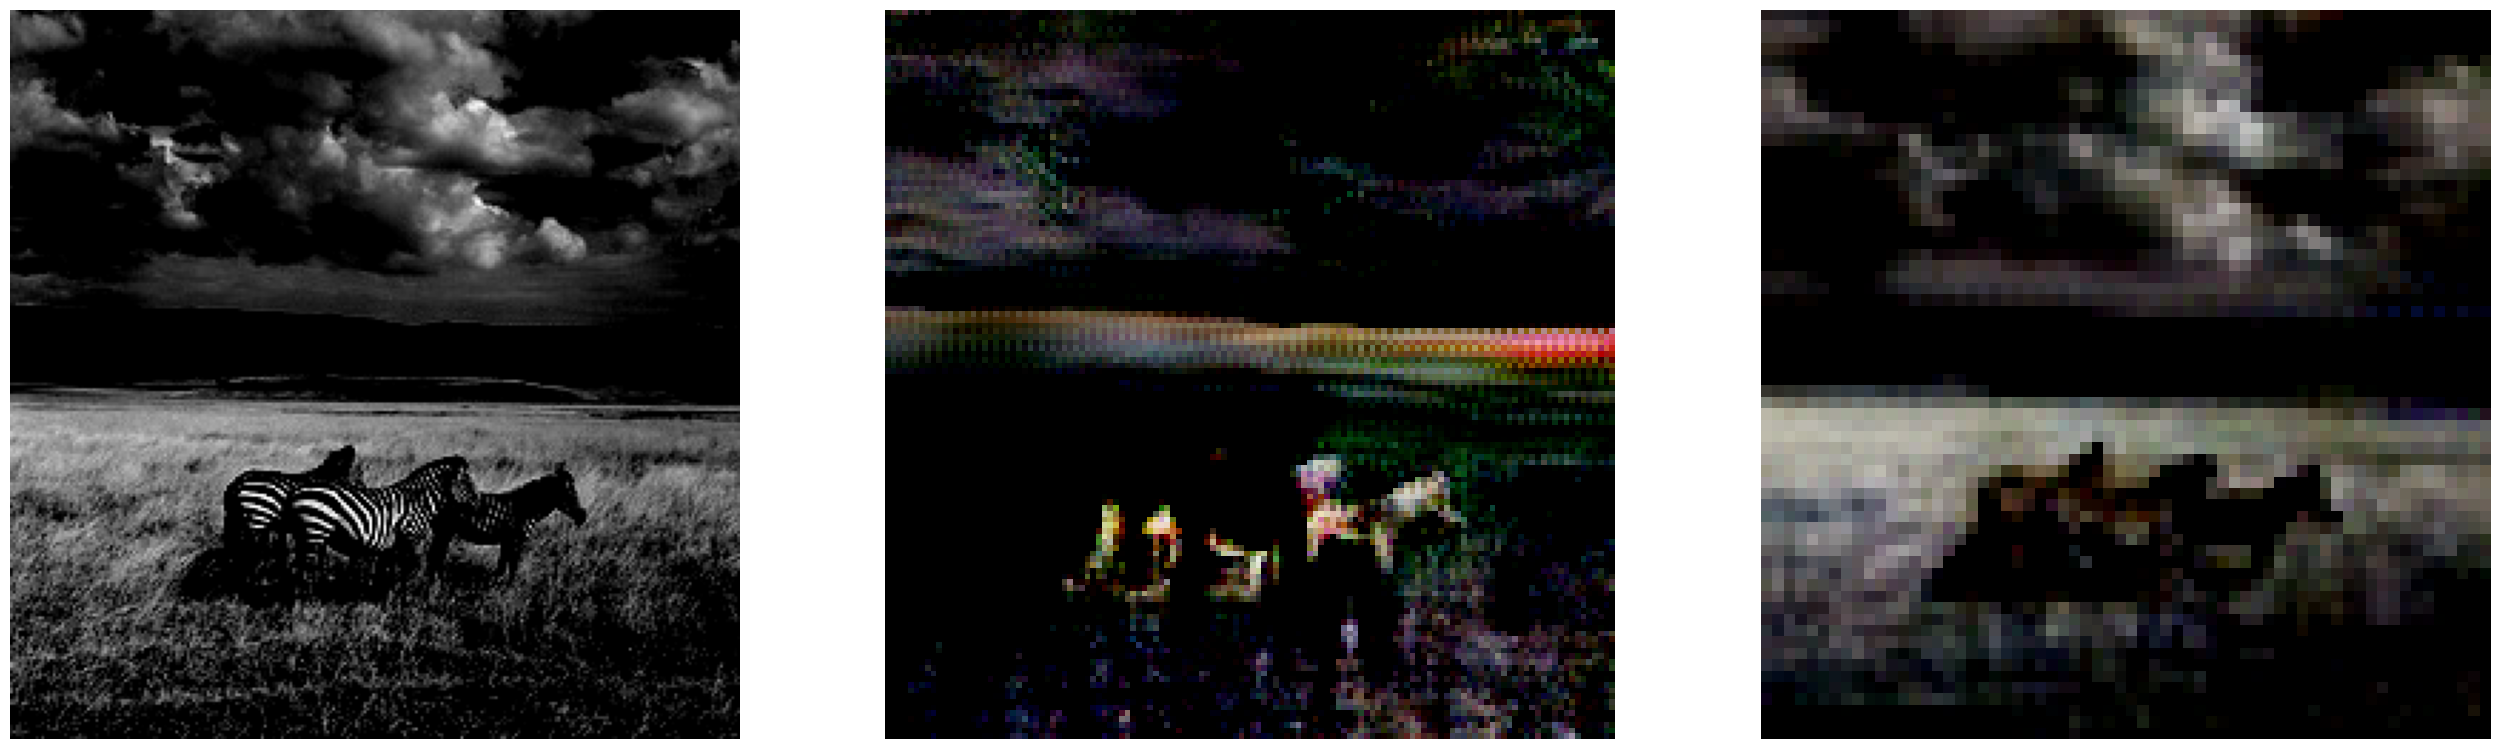

 35%|███▌      | 49/140 [00:04<00:06, 13.60it/s, D_loss=0.0968, G_loss=2.45, H_fake=0.103, H_real=0.822] 

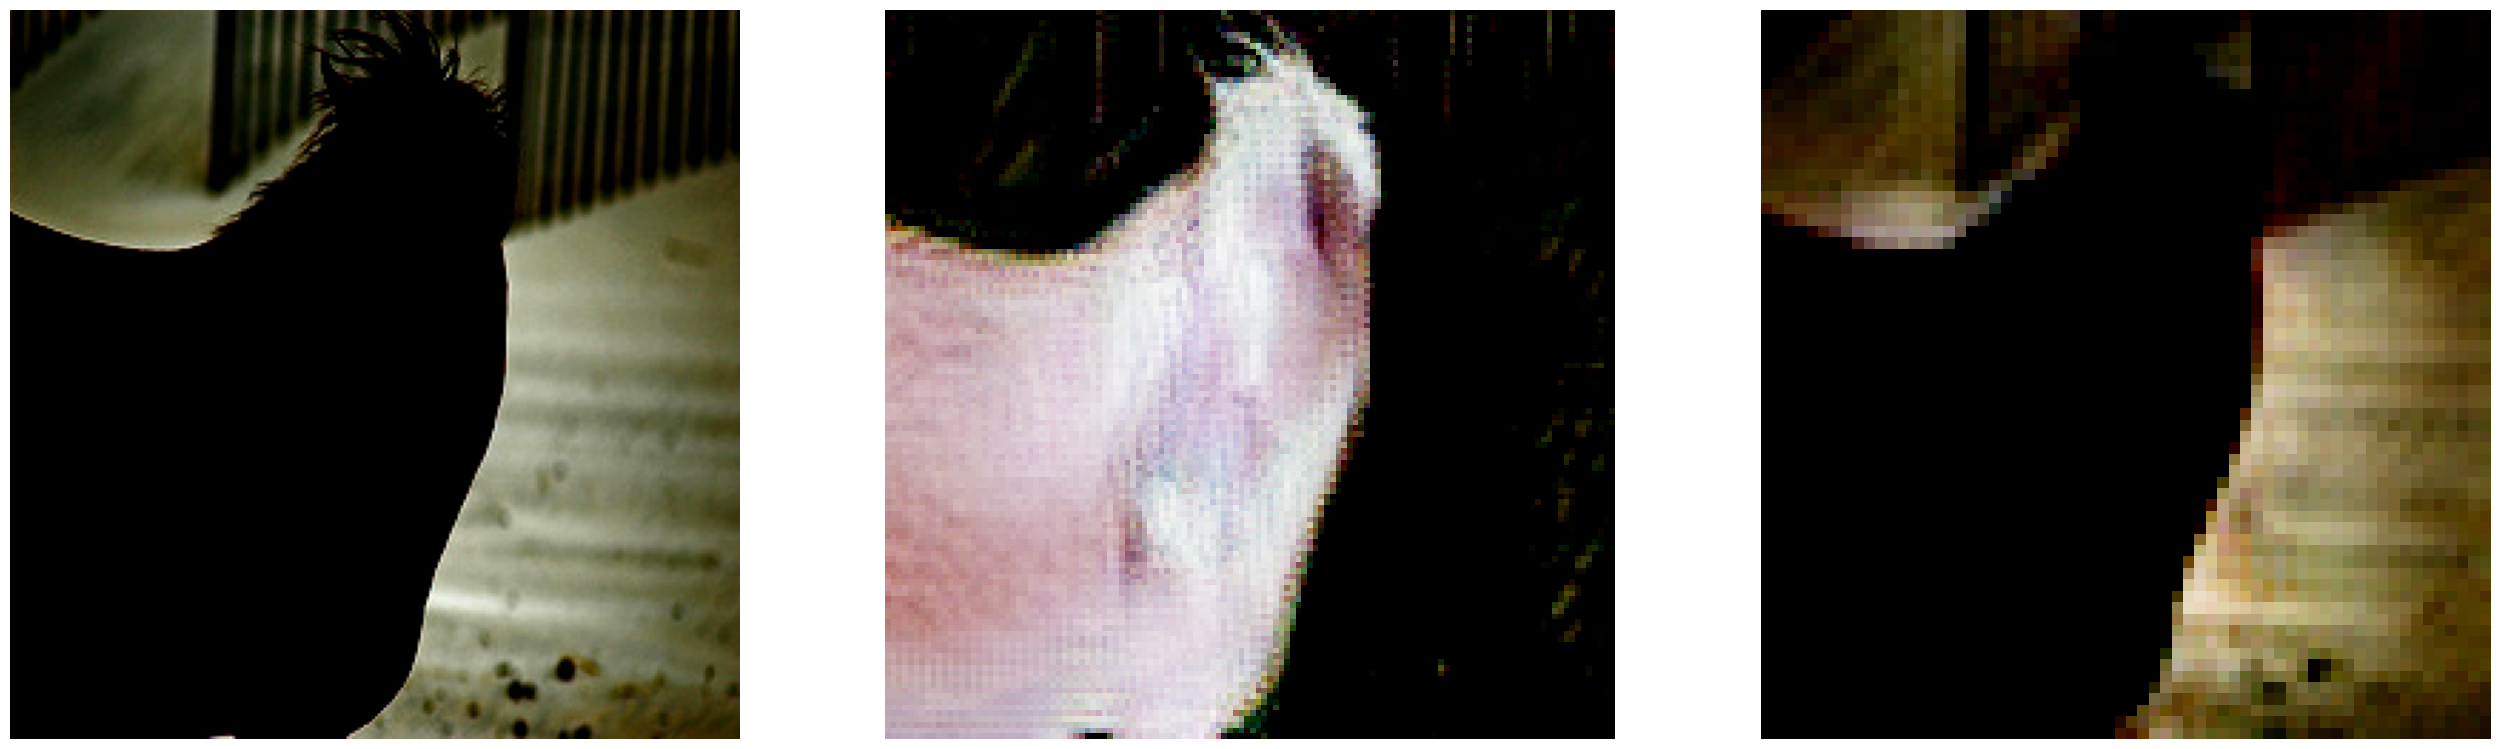

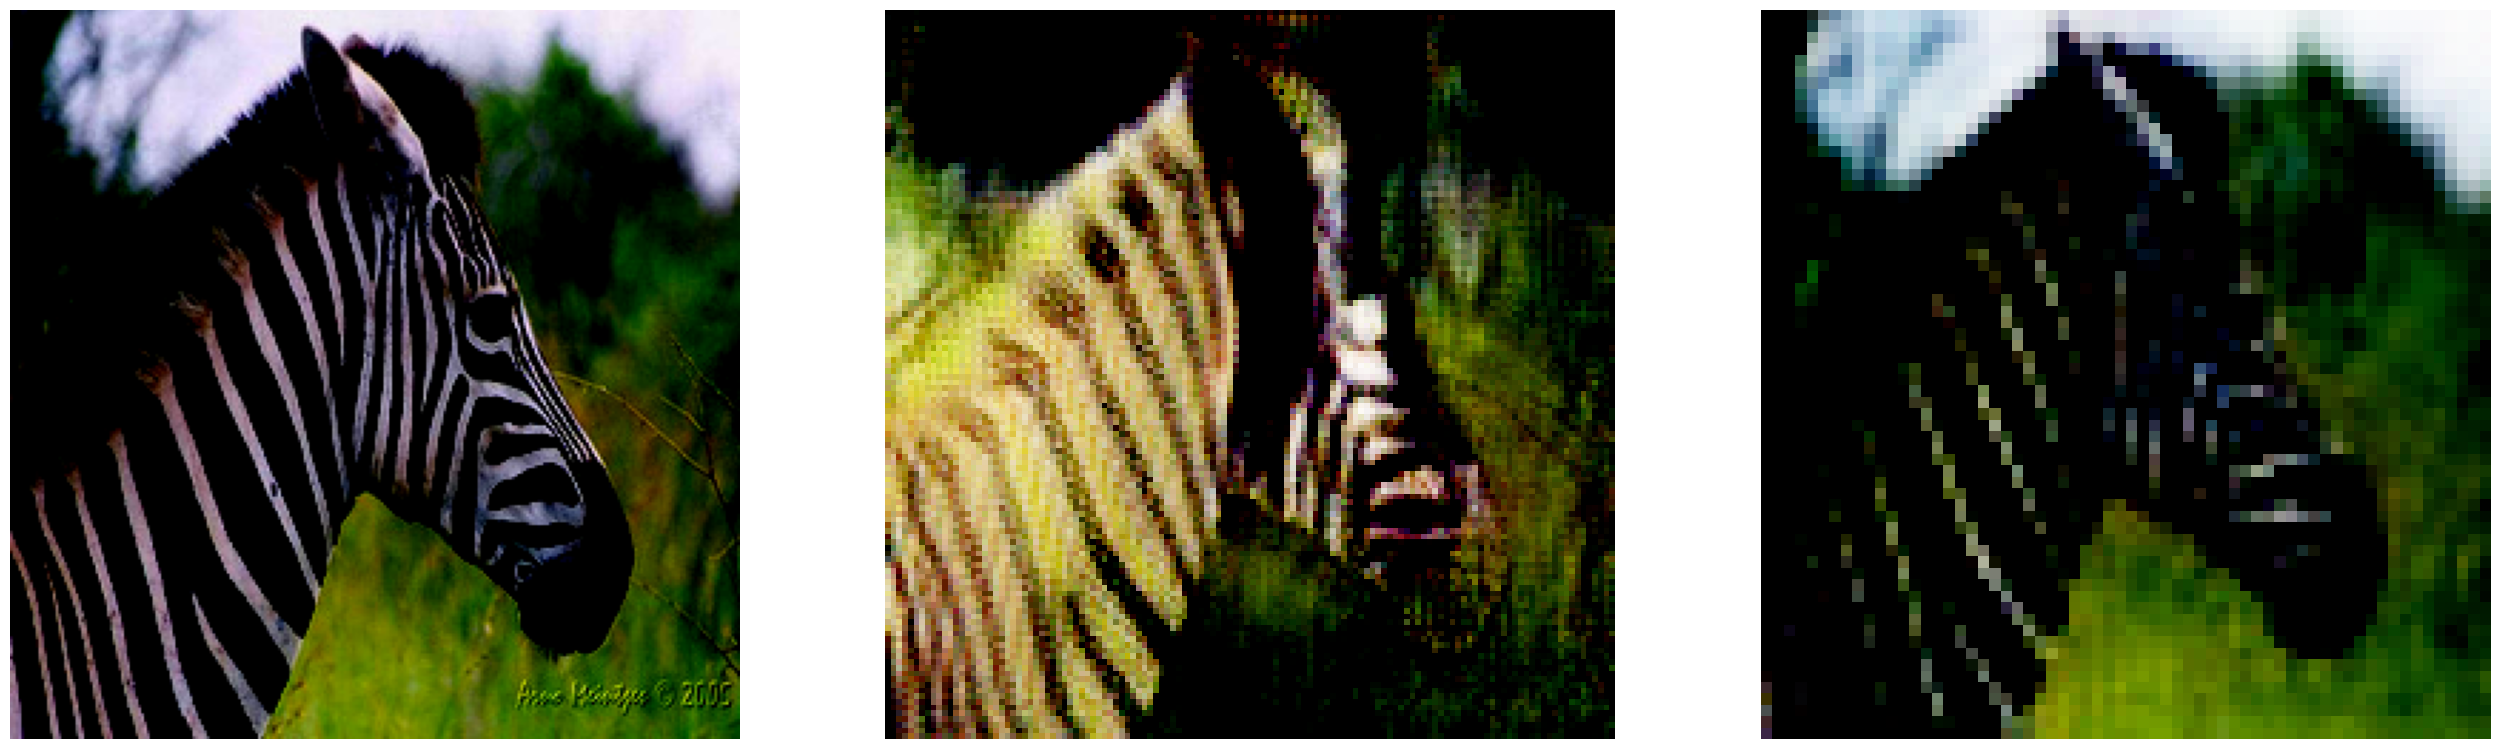

 71%|███████   | 99/140 [00:09<00:03, 13.47it/s, D_loss=0.049, G_loss=3.27, H_fake=0.0941, H_real=0.812] 

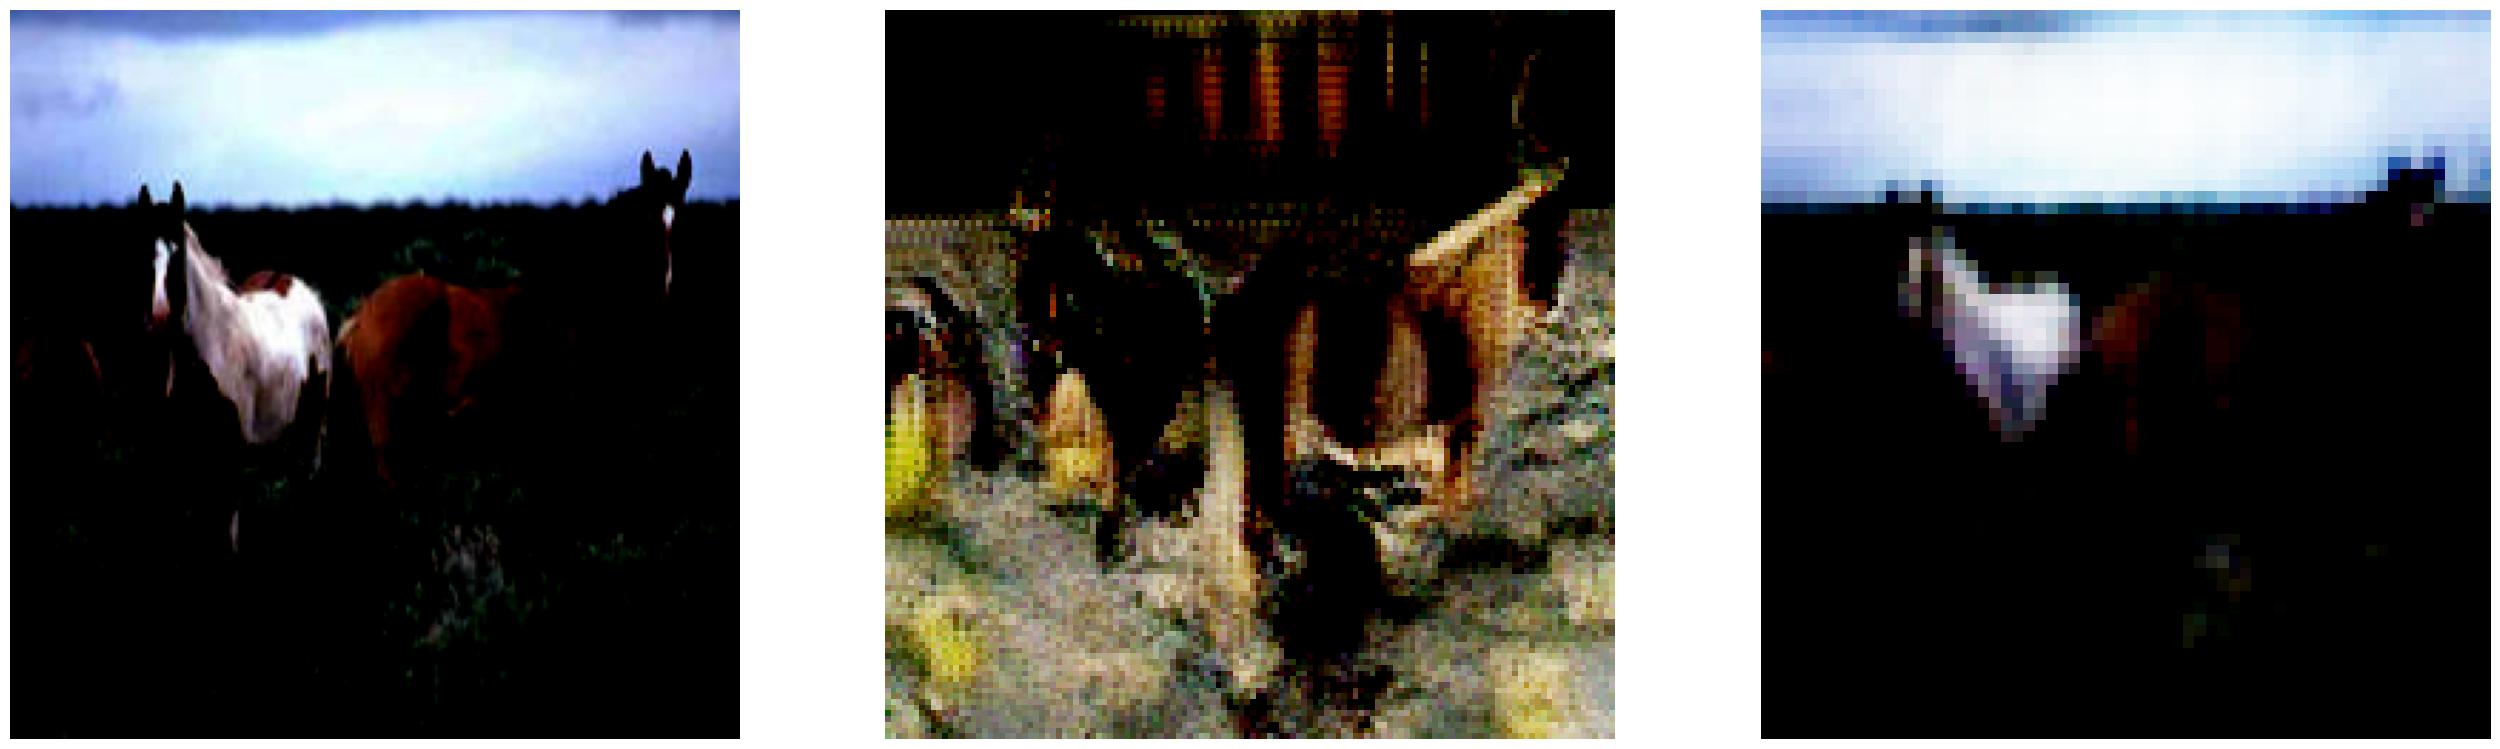

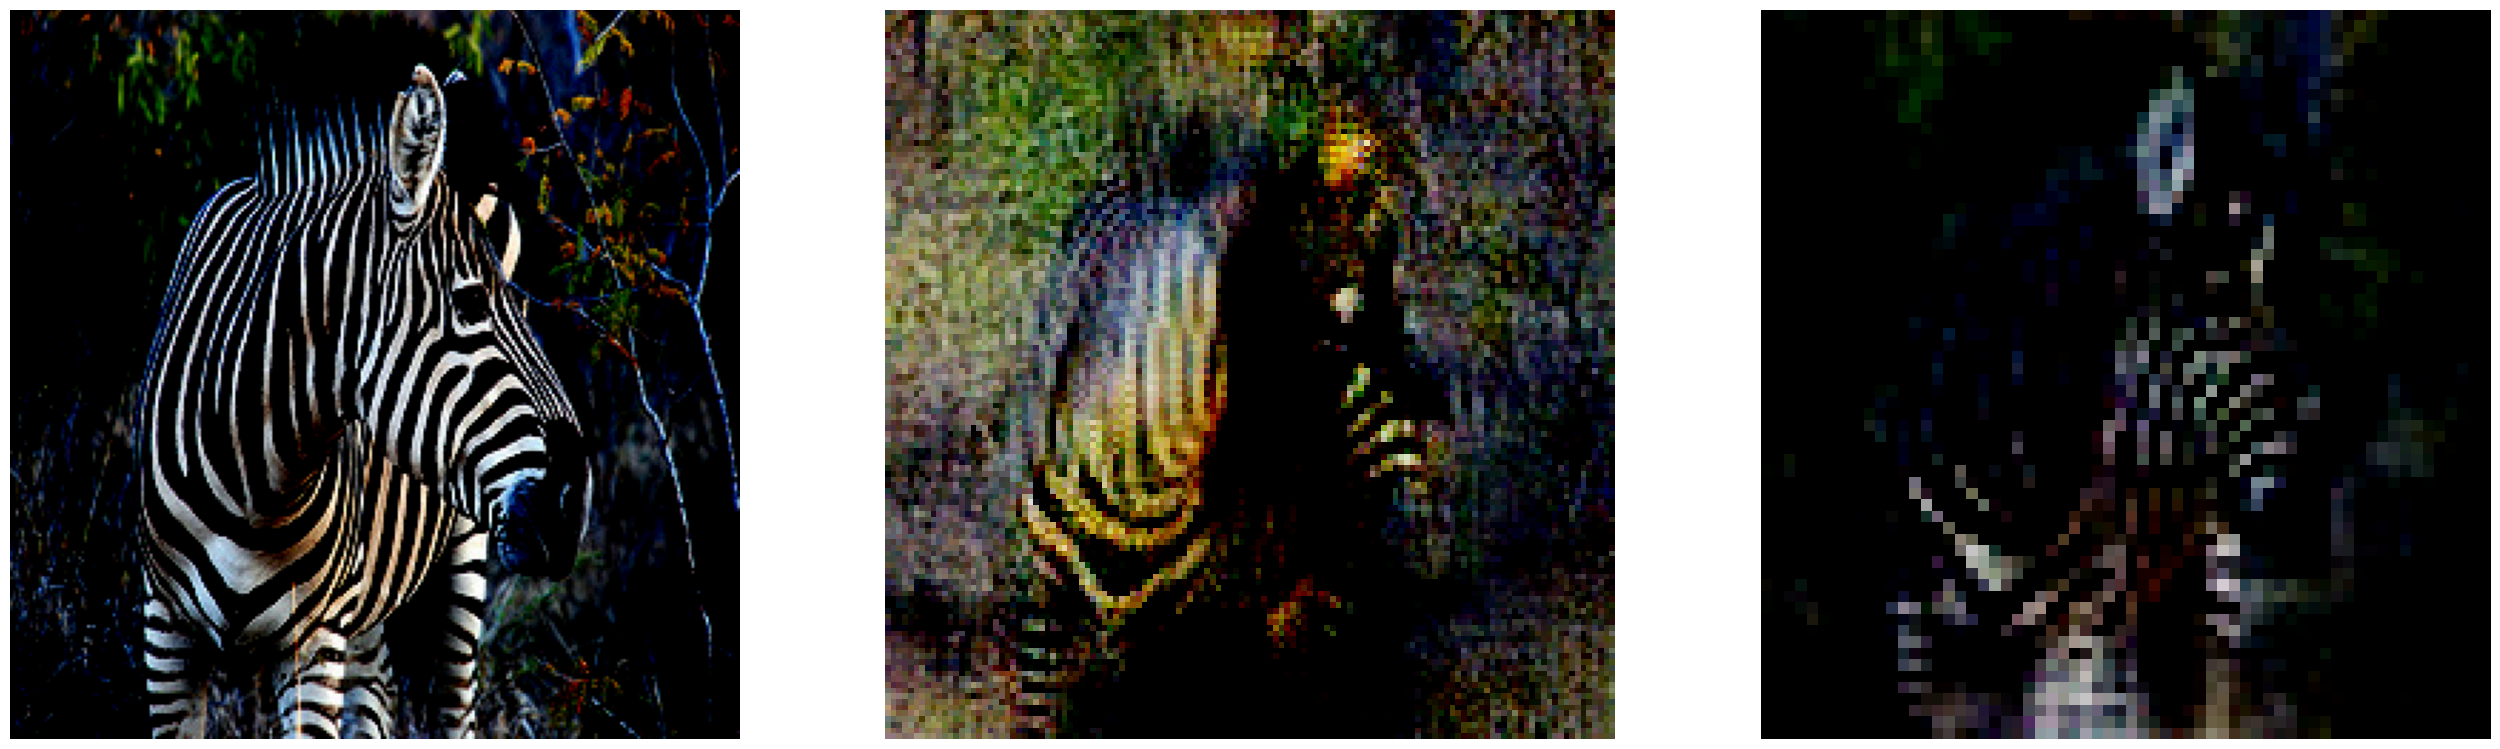

100%|██████████| 140/140 [00:13<00:00, 10.45it/s, D_loss=0.0416, G_loss=2.78, H_fake=0.094, H_real=0.824] 


In [70]:
def main():
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)

    # use Adam Optimizer for both generator and discriminator
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GENERATOR_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GENERATOR_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISCRIMINATOR_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = HorseZebraDataset(
        root_horse=TRAIN_DIR + "/trainA",
        root_zebra=TRAIN_DIR + "/trainB",
        transform=transforms,
    )
    val_dataset = HorseZebraDataset(
        root_horse=VAL_DIR + "/testA",
        root_zebra=VAL_DIR + "/testB",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
        )
        
        test_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            val_loader,
            L1,
            mse,
        )

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GENERATOR_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GENERATOR_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_Z)
            
    train_dataset_steps = len(loader)
    epoch = len(train_d_losses) // train_dataset_steps
    avg_train_d_losses = [train_d_losses[dataset * train_dataset_steps:dataset * train_dataset_steps + BATCH_SIZE] for dataset in range(0, epoch)]
    avg_train_d_losses = [np.mean(losses) for losses in avg_train_d_losses]
    
    val_dataset_steps = len(val_loader)
    epoch = len(val_losses) // val_dataset_steps
    avg_val_d_losses = [val_losses[dataset * val_dataset_steps:dataset * val_dataset_steps + BATCH_SIZE] for dataset in range(0, epoch)]
    avg_val_d_losses = [np.mean(losses) for losses in avg_val_d_losses]
    
    plt.plot(avg_train_d_losses, 'red')
    plt.plot(avg_val_d_losses, 'blue')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.legend(["Train", "Validation"], loc ="upper left") 
    plt.show()
    
    train_dataset_steps = len(loader)
    epoch = len(train_g_losses) // train_dataset_steps
    avg_train_g_losses = [train_g_losses[dataset * train_dataset_steps:dataset * train_dataset_steps + BATCH_SIZE] for dataset in range(0, epoch)]
    avg_train_g_losses = [np.mean(losses) for losses in avg_train_g_losses]
    
    plt.plot(avg_train_g_losses, 'red')
    plt.ylabel('Loss')
    plt.xlabel('Step')
    
    plt.legend(["Train"], loc ="upper left") 
    plt.show()
    
main()

In [12]:
!ls

models	outputs  state.db  val_outputs


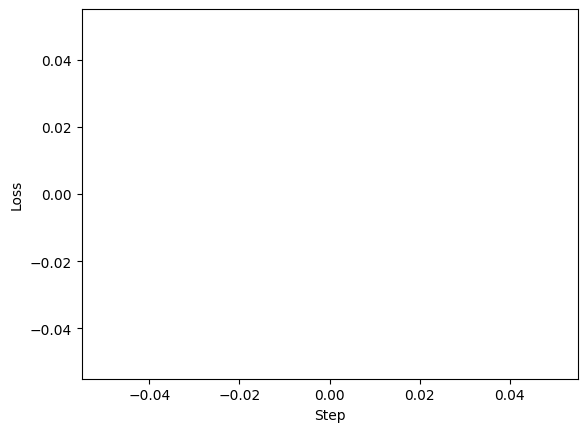

In [14]:
plt.plot(train_d_losses, 'red')
plt.plot(val_losses, 'blue')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

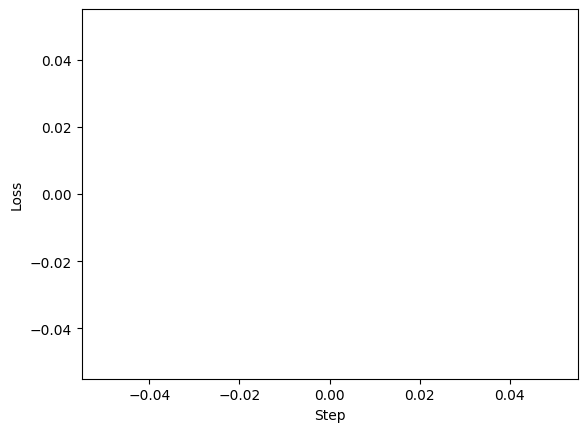

In [15]:
plt.plot(train_g_losses, 'red')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

In [16]:
%pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [17]:
from torchview import draw_graph

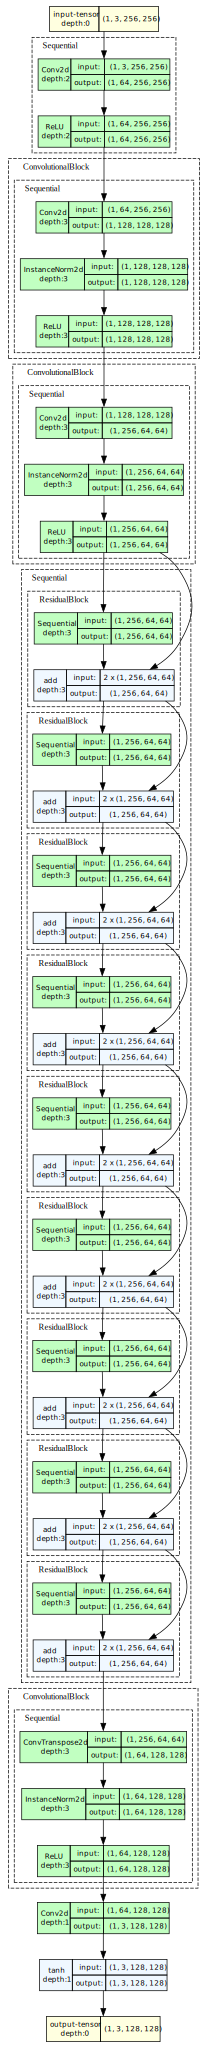

In [21]:
model_graph = draw_graph(gen_Z, input_size=(1, 3, 256, 256), expand_nested=True, save_graph=True, filename='generator', directory='/kaggle/working')
model_graph.visual_graph

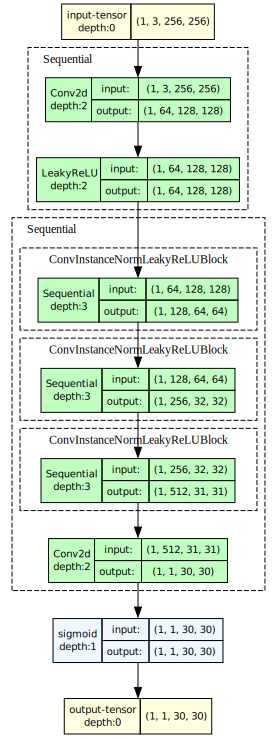

In [23]:
model_graph = draw_graph(disc_Z, input_size=(1, 3, 256, 256), expand_nested=True, save_graph=True, filename='discriminator', directory='/kaggle/working')
model_graph.visual_graph